In [14]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

### Helper Functions

In [2]:
# wrapper to show dataset images
def show_image(img, label):
    plt.imshow(img, cmap='gray')
    plt.title("Label for the image is {}".format(label))

# print at most 5 images and discards the rest
def show_images(images):
    num_images = len(images)
    nrows = 1
    ncols = min(5, num_images)
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for i in range(ncols):
        axeslist.ravel()[i].imshow(images[i], cmap='gray')
        axeslist.ravel()[i].set_axis_off()

# print out model accuracy and confusion matrix
def get_metrics(model, x, y):
    assert len(x) == len(y), "datapoints and labels are not of the same length"
    pred = np.argmax(model.predict(x), axis=1, keepdims=False).astype("uint8")
    accuracy = np.count_nonzero(y - pred == 0) / len(y)
    conf_matrix = confusion_matrix(y, pred)
    print("")
    print("Model Accuracy: {0:.2f}%".format(accuracy*100))
    print("")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("")
    plt.matshow(conf_matrix, cmap='gray')

# Initial Training of Model (Optional Section)

### Load Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
print("The training set contains {} datapoints".format(len(x_train)))
print("The test set contains {} datapoints".format(len(x_test)))
print("Each image is of size: {}".format(x_train[0].shape))

The training set contains 60000 datapoints
The test set contains 10000 datapoints
Each image is of size: (28, 28)


The cell below shows what the images from the dataset looks like \
MNIST, the dataset we're using, is comprised of handwritten digits from 0 - 9 \
Each image is 28x28 pixels \
Feel free to change the indexing below to get different images (e.g [5:10], [100:105], ...)

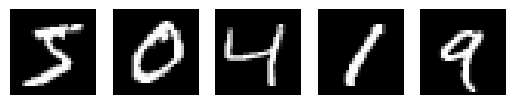

In [5]:
img_multi = x_train[:5]
show_images(img_multi)

You can view a single image from the dataset below by changing the index

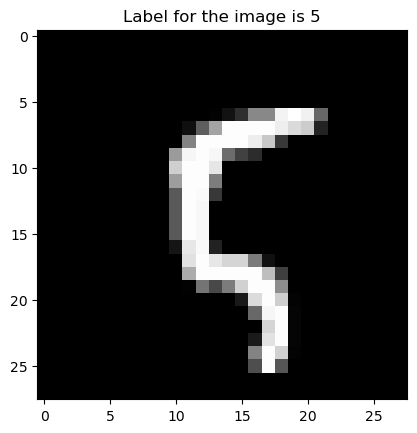

In [6]:
idx = 100
show_image(x_train[idx], y_train[idx])

In [7]:
# Normalize data and split training set -> train + validation set
x_train, x_test = x_train/255, x_test/255
x_train, x_valid = x_train[:55000], x_train[55000:]
y_train, y_valid = y_train[:55000], y_train[55000:]

### Training the model

note: using SELU as activation will guarantee self normalization and stabilize gradients if all layers in the neural network are fully connected layers and are initialized with "lecun_norma" \
https://www.tensorflow.org/api_docs/python/tf/keras/initializers/LecunNormal \
https://arxiv.org/abs/1706.02515 - SELU paper

In [8]:
# Define model architecture
model = Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(500, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(10, activation="softmax")
])

In [9]:
# you can see an overview of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 573,910
Trainable params: 573,910
Non-trainable params: 0
_________________________________________________________________


In [10]:
# setup early stopping callback to stop model training when it stops improving and saves the best model
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [11]:
# run model training
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

# saves model
model.save("mnist_model.h5")

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2683 - accuracy: 0.9183 - val_loss: 0.1366 - val_accuracy: 0.9562
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1483 - accuracy: 0.9552 - val_loss: 0.1091 - val_accuracy: 0.9674
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1121 - accuracy: 0.9658 - val_loss: 0.1142 - val_accuracy: 0.9702
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0965 - accuracy: 0.9713 - val_loss: 0.1274 - val_accuracy: 0.9682
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0832 - accuracy: 0.9746 - val_loss: 0.1077 - val_accuracy: 0.9722
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0740 - accuracy: 0.9773 - val_loss: 0.1124 - val_accuracy: 0.9730
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0629 - accuracy: 0.9808 - val_loss: 0.1278 - val_accuracy:

### Model Evaluation

Now that we have trained the model on the training set, we're going to check how the model performs on unseen data. This is important to prevent overfitting, where a model is unable to generalize well to unseen data since it has "memorized" the training data. \
https://en.wikipedia.org/wiki/Overfitting \
\
We are using our own custom function to get include a confusion matrix but tensorflow has its own native function .evaluate(datapoints, labels) which will show something like: \
\
313/313 [==============================] - 1s 2ms/step - loss: 0.1207 - accuracy: 0.9681

313/313 [==============================] - 0s 1ms/step

Model Accuracy: 96.81%

Confusion Matrix:
[[ 966    0    0    2    0    1    4    1    6    0]
 [   6 1112    2    1    2    1    2    2    7    0]
 [   2    1 1001    9    2    0    3    5    9    0]
 [   0    0    9  976    0    7    0    5   12    1]
 [   1    0    0    0  959    0   12    0    5    5]
 [   2    0    0   21    1  842   10    3   11    2]
 [   3    2    0    0    1    6  945    0    1    0]
 [   2    2   15    1    5    0    0  994    5    4]
 [   1    1    2    4    0    3    1    6  955    1]
 [   2    3    0    7   10    7    2   28   19  931]]



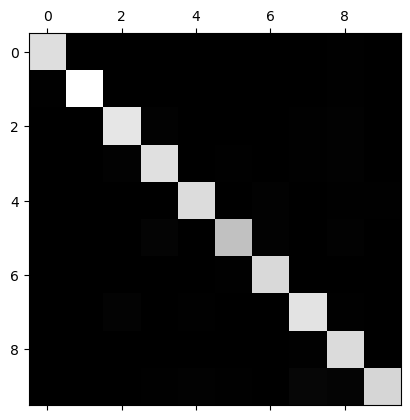

In [121]:
get_metrics(model, x_test, y_test)

# Reverse Engineering The Model

In this step, we assume that we have the model but no datapoints at all. What we want to do here is to create synthetic datapoints and run them through the model to get the model's output. The model's output is represented as a probability distribution over predicted output classes. This distribution sums to 1. The class with the highest probability during inference is the chosen as the prediction value.

In [5]:
# loading the model we trained
# you can skip this step if you're continuing from above
model = keras.models.load_model('mnist_model.h5')

In [21]:
# This cell shows the output of the model
output = model.predict(x_test[:1])
class_prediction = np.argmax(output)
print(output)
print("")
print("predicted class: {}".format(class_prediction))

1/1 [==============================] - 0s 12ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

predicted class: 7


In [15]:
# load synthetic images made of random numbers
# you can find the script to generate the images at the bottom of this notebook
# here we are just loading the data
x_synthetic = np.load('synthetic_mnist_data.npy')
y_synthetic = np.load('synthetic_mnist_labels.npy')

x_synthetic, y_synthetic = shuffle(x_synthetic, y_synthetic, random_state=26)

assert(len(x_synthetic) == len(y_synthetic))
assert(x_synthetic.shape == (139118, 28, 28))
assert(y_synthetic.shape == (139118,))

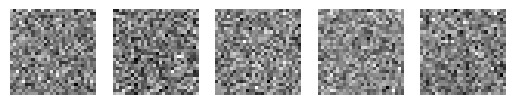

In [20]:
# you can see what each generated datapoints look like
# note that they do not look like handwritten digits or represent anything
show_images(x_synthetic[:5])

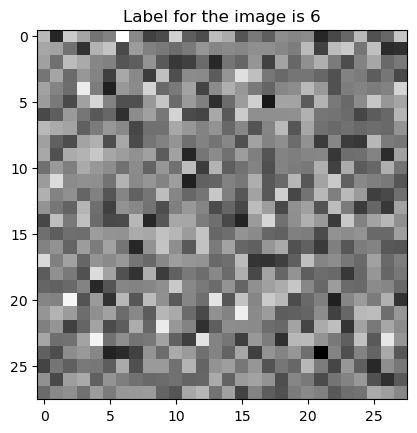

In [68]:
show_image(x_synthetic[0], y_synthetic[0])

Previously we mentioned that we want to avoid overfitting so that the model can generalize well. Now, we intentionally want to overfit the model to approximate the function of the model we want to clone.

In [59]:
# Define cloned model architecture
model_clone = Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(500, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(400, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(200, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(10, activation="softmax")
])

In [60]:
model_clone.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 500)               392500    
                                                                 
 dense_11 (Dense)            (None, 400)               200400    
                                                                 
 dense_12 (Dense)            (None, 300)               120300    
                                                                 
 dense_13 (Dense)            (None, 200)               60200     
                                                                 
 dense_14 (Dense)            (None, 100)               20100     
                                                                 
 dense_15 (Dense)            (None, 10)               

In [61]:
# model training step
# model_clone.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model_clone.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [49]:
# run this cell if you defined early stopping in the section above
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [62]:
model_clone.fit(x_synthetic, y_synthetic, batch_size=16, epochs=20, validation_data=(x_synthetic, y_synthetic), callbacks=[early_stopping])

Epoch 1/20
8695/8695 [==============================] - 36s 4ms/step - loss: 1.3755 - accuracy: 0.5126 - val_loss: 1.0777 - val_accuracy: 0.6149
Epoch 2/20
8695/8695 [==============================] - 37s 4ms/step - loss: 0.9982 - accuracy: 0.6444 - val_loss: 0.7472 - val_accuracy: 0.7306
Epoch 3/20
8695/8695 [==============================] - 35s 4ms/step - loss: 0.7605 - accuracy: 0.7273 - val_loss: 0.5767 - val_accuracy: 0.7963
Epoch 4/20
8695/8695 [==============================] - 39s 4ms/step - loss: 0.8179 - accuracy: 0.7733 - val_loss: 0.8324 - val_accuracy: 0.7946
Epoch 5/20
8695/8695 [==============================] - 34s 4ms/step - loss: 0.8068 - accuracy: 0.7859 - val_loss: 0.5571 - val_accuracy: 0.8338
Epoch 6/20
8695/8695 [==============================] - 38s 4ms/step - loss: 0.4964 - accuracy: 0.8262 - val_loss: 0.3468 - val_accuracy: 0.8814
Epoch 7/20
8695/8695 [==============================] - 34s 4ms/step - loss: 0.4197 - accuracy: 0.8548 - val_loss: 0.2789 - val_ac

In [63]:
# save cloned model
model_clone.save("mnist_model_clone.h5")

313/313 [==============================] - 0s 1ms/step

Model Accuracy: 54.65%

Confusion Matrix:
[[ 25   0   2  44   0 858  14  23  13   1]
 [  0 615   5 464   0  35   1  10   5   0]
 [  3   0 361 139   0 432   0  97   0   0]
 [  0   0   1 979   0  22   0   7   1   0]
 [ 15   2   2  59   3  30  21 818   6  26]
 [  2   0   0  72   0 813   0   2   1   2]
 [  0   0   0  22   0  21 909   6   0   0]
 [  0   2   3  25   0   9   0 974   1  14]
 [  0   0   0 937   0  26   0   9   1   1]
 [  2   3   1 184   0  14   2  15   3 785]]



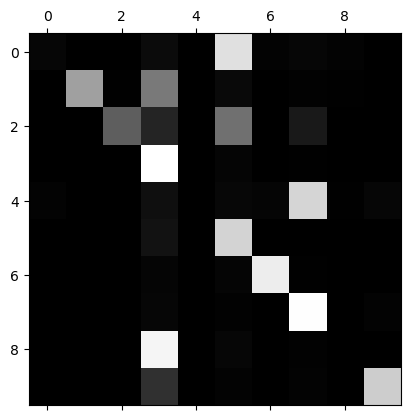

In [64]:
get_metrics(model_clone, x_test, y_test)

In [65]:
d = {}
for i in y_test:
    if i in d:
        d[i] += 1
    else:
        d[i] = 1
print(d)

{7: 1028, 2: 1032, 1: 1135, 0: 980, 4: 982, 9: 1009, 5: 892, 6: 958, 3: 1010, 8: 974}


## Data Gen (Optional Section)

In [5]:
gen = np.random.randn(1000000, 28, 28)

In [6]:
preds = model.predict(tf.convert_to_tensor(gen))

31250/31250 [==============================] - 35s 1ms/step


In [7]:
preds.shape

(1000000, 10)

In [8]:
labels = np.argmax(preds, axis=1)

In [9]:
generated_data = {}
for i in range(10):
    l = labels==i
    gx = gen[l]
    generated_data[i] = gx
    print("for label {}, random has generated {}".format(i, gx.shape))

for label 0, random has generated (10063, 28, 28)
for label 1, random has generated (150146, 28, 28)
for label 2, random has generated (177533, 28, 28)
for label 3, random has generated (209448, 28, 28)
for label 4, random has generated (62630, 28, 28)
for label 5, random has generated (133597, 28, 28)
for label 6, random has generated (42259, 28, 28)
for label 7, random has generated (175199, 28, 28)
for label 8, random has generated (9055, 28, 28)
for label 9, random has generated (30070, 28, 28)


In [11]:
concat = generated_data[0]
for i in range(1, 10):
    to_add = generated_data[i][:15000]
    concat = np.concatenate((concat, to_add))

In [12]:
concat.shape

(139118, 28, 28)

In [13]:
(15000*8) + 10063 + 9055

139118

In [14]:
np.save('synthetic_mnist_data.npy', concat)

In [17]:
labels = []
for i in range(10):
    if i == 0:
        labels += [0 for j in range(10063)]
    elif i == 8:
        labels += [8 for j in range(9055)]
    else:
        labels += [i for j in range(15000)]

In [18]:
len(labels)

139118

In [19]:
np_labels = np.array(labels)

In [20]:
np_labels.shape

(139118,)

In [21]:
np.save('synthetic_mnist_labels.npy', np_labels)